# Analysis of differential expression across conditions

In [1]:
import pandas as pd
from diffexpr.py_deseq import py_DESeq2
from rpy2.robjects import Formula
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR) 

counts = pd.read_csv('Data/DokdoniaCounts.csv', index_col=0)
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts.head()

,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3_T1,D_18_R3,D_18_R4,D_25_R1,D_25_R2,...,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4_T1,L_34_R4_T2,L_34_R4_T3,L_34_R4
MED134_07389,12973,11426,13251,30624,30618,25566,41014,22449,53840,32369,...,39444,41721,37020,39662,30983,27280,43105,44946,39311,57834
MED134_07384,1557,1555,1552,4160,4385,3383,5588,2940,7550,4509,...,5419,5536,5318,5396,4751,4285,5108,4924,4503,7818
MED134_07379,3400,3319,3273,7218,7903,6315,9539,5040,13268,7572,...,9089,9016,8529,10179,7617,7207,9484,8837,8743,13827
MED134_07374,1987,2124,1404,3509,3772,2846,4337,2602,4607,3316,...,3586,3594,3488,4158,3096,2623,3818,3792,3538,5323
MED134_07369,2087,2010,2111,3774,3809,2921,4486,2901,4668,3456,...,3705,4158,3760,5518,3563,2713,3679,3543,3356,5150


In [2]:
# Removing genes with low read counts across samples
min_count = 10
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)
counts.head()

,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3_T1,D_18_R3,D_18_R4,D_25_R1,...,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4_T1,L_34_R4_T2,L_34_R4_T3,L_34_R4
0,MED134_07389,12973,11426,13251,30624,30618,25566,41014,22449,53840,...,39444,41721,37020,39662,30983,27280,43105,44946,39311,57834
1,MED134_07384,1557,1555,1552,4160,4385,3383,5588,2940,7550,...,5419,5536,5318,5396,4751,4285,5108,4924,4503,7818
2,MED134_07379,3400,3319,3273,7218,7903,6315,9539,5040,13268,...,9089,9016,8529,10179,7617,7207,9484,8837,8743,13827
3,MED134_07374,1987,2124,1404,3509,3772,2846,4337,2602,4607,...,3586,3594,3488,4158,3096,2623,3818,3792,3538,5323
4,MED134_07369,2087,2010,2111,3774,3809,2921,4486,2901,4668,...,3705,4158,3760,5518,3563,2713,3679,3543,3356,5150


In [3]:
meta = pd.DataFrame({
    'lighting': [s[0] for s in conditions],
    'temperature': [s[2:4] for s in conditions],
    'replicate': [s[5:] for s in conditions]
    }, index=conditions)
meta.head()

,lighting,temperature,replicate
D_10_R1,D,10,R1
D_10_R2,D,10,R2
D_10_R3,D,10,R3
D_18_R1,D,18,R1
D_18_R2,D,18,R2


In [10]:
dds = py_DESeq2(count_matrix = counts,
               design_matrix = meta,
               design_formula = '~ temperature',
               gene_column = 'index')
    
dds.run_deseq() 
dds.get_deseq_result()
res = dds.deseq_result 
res.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,index
MED134_07389,28703.140067,0.943521,0.075685,12.466465,1.137610e-35,7.455364e-35,MED134_07389
MED134_07384,3910.065668,1.131689,0.059654,18.970839,2.971240e-80,6.730911e-79,MED134_07384
MED134_07379,6943.980527,0.905642,0.044703,20.259267,2.943101e-91,8.640104e-90,MED134_07379
MED134_07374,2984.962379,0.366559,0.064449,5.687591,1.288442e-08,2.699815e-08,MED134_07374
MED134_07369,3263.281489,0.206131,0.085757,2.403676,1.623116e-02,2.118741e-02,MED134_07369


In [5]:
from rpy2.robjects import Formula

dds = py_DESeq2(count_matrix = counts,
               design_matrix = meta,
               design_formula = '~ lighting + temperature',
               gene_column = 'index')
    
dds.run_deseq(test="LRT", reduced = '~ temperature') #Formula('~ temperature')) 
dds.get_deseq_result()
res = dds.deseq_result 
res.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,index
MED134_07389,28703.140067,0.929417,0.068123,8.219448,0.004144,0.036370,MED134_07389
MED134_07384,3910.065668,1.126363,0.058066,2.552688,0.110107,0.290021,MED134_07384
MED134_07379,6943.980527,0.902783,0.044693,0.759554,0.383468,0.612028,MED134_07379
MED134_07374,2984.962379,0.355939,0.060944,4.333562,0.037368,0.150595,MED134_07374
MED134_07369,3263.281489,0.185948,0.069584,17.516562,0.000028,0.001099,MED134_07369


In [2]:
import pandas as pd
tpm = pd.read_csv('Data/tpm_counts.csv', index_col=0)
tpm.head()

,D_10_R1.sam,D_10_R2.sam,D_10_R3.sam,D_18_R1.sam,D_18_R2.sam,D_18_R3_T1.sam,D_18_R3.sam,D_18_R4.sam,D_25_R1.sam,D_25_R2.sam,...,L_25_R1.sam,L_25_R2.sam,L_25_R3.sam,L_34_R1.sam,L_34_R2.sam,L_34_R3.sam,L_34_R4_T1.sam,L_34_R4_T2.sam,L_34_R4_T3.sam,L_34_R4.sam
MED134_07389,126.651810,103.199290,132.954350,207.076817,186.093462,230.692835,232.104483,217.039083,319.508620,287.121249,...,309.890336,332.917481,319.950739,279.889139,329.788952,298.880372,360.335351,386.297760,364.639362,342.590660
MED134_07384,93.133592,86.051736,95.409665,172.349350,163.294159,187.033790,193.755730,174.154632,274.518258,245.054704,...,260.851290,270.660405,281.605927,233.308269,309.844950,287.640881,261.623569,259.296074,255.916424,283.749242
MED134_07379,98.558447,89.008953,97.508810,144.920691,142.623218,169.195430,160.286964,144.682310,233.790545,199.430055,...,212.025033,213.618935,218.871276,213.285093,240.735725,234.450684,235.404478,225.517345,240.798561,243.200355
MED134_07374,216.411361,214.016968,157.156450,264.706216,255.762687,286.495249,273.811718,280.646379,305.004991,328.141969,...,314.303035,319.941937,336.305821,327.346067,367.641724,320.599267,356.062594,363.588951,366.115816,351.770941
MED134_07369,287.031906,255.749791,298.386295,359.507705,326.138456,371.312544,357.641093,395.116727,390.251982,431.863528,...,410.064372,467.415509,457.795258,548.567247,534.275427,418.735291,433.257163,428.981967,438.538927,429.770161


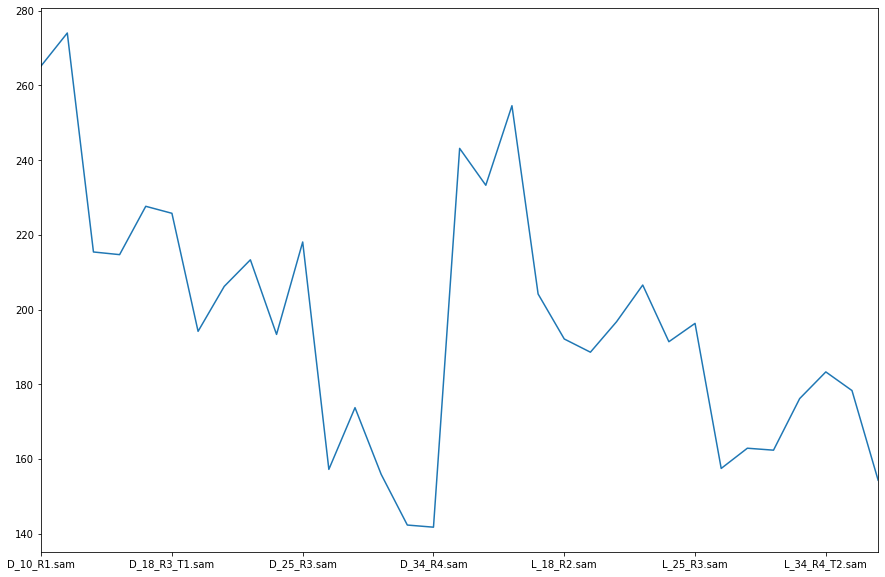

In [4]:
# log2 fold change: -1.034
# peptide chain release factor RF-3
gene_id = 'MED134_14802'
tpm.loc[gene_id].plot(legend=False, figsize=(15, 10))

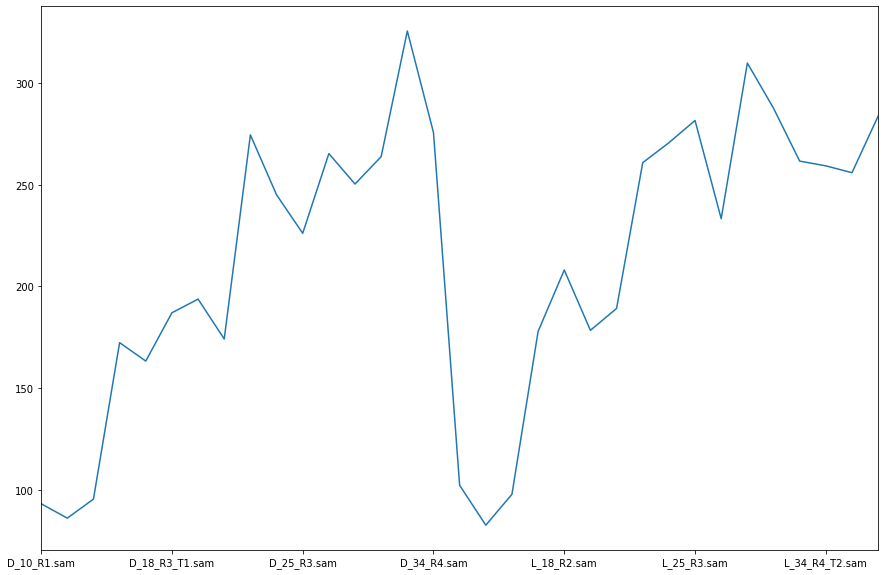

In [5]:
# Log 2 fold change: 1.13
# Type IX secretion system membrane protein, PorP/SprF family
gene_id = 'MED134_07384'
tpm.loc[gene_id].plot(legend=False, figsize=(15, 10))